In [1]:
import optuna
import os
import sys 
import inspect
import utils.h5_utils as h5
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix
import pandas as pd
from utils.constants import *
import matplotlib.pyplot as plt
import copy

import npyx

# Confusion matrix
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42 # necessary to make the text editable
matplotlib.rcParams['ps.fonttype'] = 42


cupy could not be imported - some functions dealing with the binary file (filtering, whitening...) will not work.
npyx version 2.5.2 imported.


# SSVAE confusion matrix

In [2]:
f1_list = []
accuracy_list = []
confusion_list = []
for x in range(3000):
    if os.path.exists(f"models/SSVAE saves/f1_score_seed_{x}.pkl"):
        f1 = h5.load(f"models/SSVAE saves/f1_score_seed_{x}.pkl")
        preds = h5.load(f"models/SSVAE saves/predicted_targets_seed_{x}.pkl")
        true = np.array(h5.load(f"models/SSVAE saves/true_targets_run_seed_{x}.pkl")).ravel()
        confusion = h5.load(f"models/SSVAE saves/confusion_matrix_seed_{x}.pkl")
        accuracy = (true==preds).mean()
        f1_list.append(f1)
        accuracy_list.append(accuracy)
        confusion_list.append(confusion)
    else:
        continue
f1s = np.array(f1_list)
accuracies = np.array(accuracy_list)
print(f"Mean F1 score: {f1s.mean()}, std F1 score: {f1s.std()}")
print(f"Mean accuracy: {accuracies.mean()}, std accuracy: {accuracies.std()}")

Mean F1 score: 0.6542471634380896, std F1 score: 0.0780955624603214
Mean accuracy: 0.6930342384887839, std accuracy: 0.09785768965809732


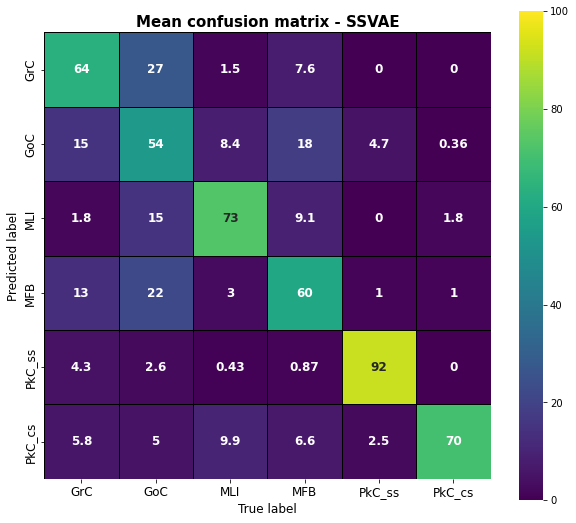

In [3]:
confusion = np.stack(confusion_list, axis = 2).mean(axis = 2) # confusion_matrix(true_2, predicted_2, labels = np.arange(0,6))
mean_confusion = confusion / (np.sum(confusion, axis = 1)[:, np.newaxis]) * 100 # normalising and showing percentage
mask = ~(np.eye(mean_confusion.shape[0]).astype(bool))

fig, ax = plt.subplots(figsize=(10, 9))
ax = sns.heatmap(
    mean_confusion,
    annot=mean_confusion,
    cmap="viridis",
    cbar=True,
    linewidths=1,
    linecolor="black",
    square=True,
    vmin=0,
    vmax=100,
    annot_kws={"fontsize": 12, "fontweight": "bold"},
)

x_labels = [int(ax.get_xticklabels()[i].get_text()) for i in range(6)]
y_labels = [int(ax.get_yticklabels()[i].get_text()) for i in range(6)]

ax.set_xticklabels(
    pd.Series(x_labels).replace(to_replace=CORRESPONDENCE).to_numpy(),
    fontsize=12,
)
ax.set_yticklabels(
    pd.Series(y_labels).replace(to_replace=CORRESPONDENCE).to_numpy(),
    fontsize=12,
)
ax.set_title("Mean confusion matrix - SSVAE", fontsize=15, fontweight="bold")
ax.set_xlabel("True label", fontsize=12)
ax.set_ylabel("Predicted label", fontsize=12);

# plt.savefig("mean_confusion_matrix_SSVAE.pdf")

Text(103.38000000000001, 0.5, 'Predicted label')

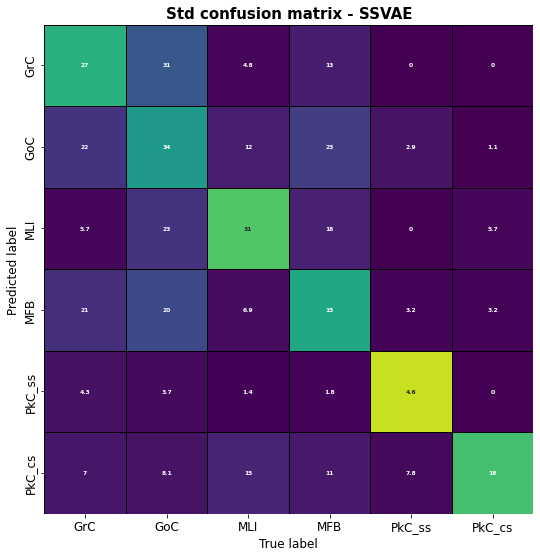

In [4]:
confusion = np.stack(confusion_list, axis=2).mean(axis=2)
mean_confusion = (
    confusion / (np.sum(confusion, axis=1)[:, np.newaxis]) * 100
)  # normalising and showing percentage
std_confusion = (
    np.stack(confusion_list, axis=2).std(axis=2)
    / (np.sum(confusion, axis=1)[:, np.newaxis])
    * 100
)  # normalising and showing percentage
mask = ~(np.eye(mean_confusion.shape[0]).astype(bool))

fig, ax = plt.subplots(figsize=(10, 9))
ax = sns.heatmap(
    mean_confusion,
    annot=std_confusion,
    cmap="viridis",
    cbar=False,
    linewidths=1,
    linecolor="black",
    square=True,
    vmin=0,
    vmax=100,
    annot_kws={
        "fontsize": 6,
        "fontweight": "bold",
        "verticalalignment": "bottom",
        "horizontalalignment": "right",
    },
)
x_labels = [int(ax.get_xticklabels()[i].get_text()) for i in range(6)]
y_labels = [int(ax.get_yticklabels()[i].get_text()) for i in range(6)]

ax.set_xticklabels(
    pd.Series(x_labels).replace(to_replace=CORRESPONDENCE).to_numpy(),
    fontsize=12,
)
ax.set_yticklabels(
    pd.Series(y_labels).replace(to_replace=CORRESPONDENCE).to_numpy(),
    fontsize=12,
)
ax.set_title("Std confusion matrix - SSVAE", fontsize=15, fontweight="bold")
ax.set_xlabel("True label", fontsize=12)
ax.set_ylabel("Predicted label", fontsize=12)
# plt.savefig("std_confusion_matrix_SSVAE.pdf")


## Recovering most common mistakes

In [5]:
f1_list = []
accuracy_list = []
confusion_list = []
boolean_preds = []
predictions = []
for x in range(3000):
    if os.path.exists(f"models/SSVAE saves/f1_score_seed_{x}.pkl"):
        f1 = h5.load(f"models/SSVAE saves/f1_score_seed_{x}.pkl")
        preds = h5.load(f"models/SSVAE saves/predicted_targets_seed_{x}.pkl")
        true = np.array(h5.load(f"models/SSVAE saves/true_targets_run_seed_{x}.pkl")).ravel()
        confusion = h5.load(f"models/SSVAE saves/confusion_matrix_seed_{x}.pkl")
        boolean_preds.append(true==preds)
        accuracy = (true==preds).mean()
        f1_list.append(f1)
        accuracy_list.append(accuracy)
        confusion_list.append(confusion)
        predictions.append(preds)
    else:
        continue
    
f1s = np.array(f1_list)
accuracies = np.array(accuracy_list)

In [6]:
mistakes = (len(boolean_preds) - np.stack(boolean_preds, axis = 0).sum(0))

In [7]:
predictions_array = np.stack(predictions, axis = 0)

In [8]:
top5_mistakes_idx = np.argsort(mistakes)[::-1][:5]
top5_mistakes_count = mistakes[top5_mistakes_idx]

In [9]:
DATASET = h5.NeuronsDataset(DATA_PATH, normalise=False)

# Choosing the scaling and the type of dataset we want (full, acg or wf)
# DATASET.min_max_scale()
DATASET.make_full_dataset()
DATASET.make_labels_only()

Reading dataset:   0%|          | 0/1213 [00:00<?, ?it/s]

954 neurons loaded, of which labelled: 77 
259 neurons discarded, of which labelled: 7. More details at the 'discarded_df' attribute.


Cell: GoC mistaken 10 times. 

Most common mislabelling: PkC_ss 



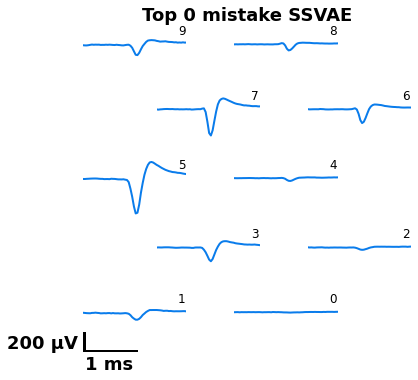

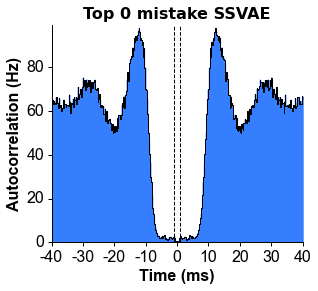


 ----- 

Cell: PkC_cs mistaken 8 times. 

Most common mislabelling: GoC 



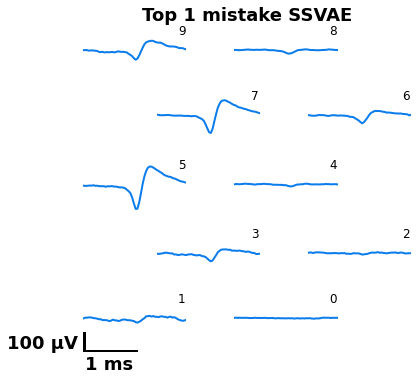

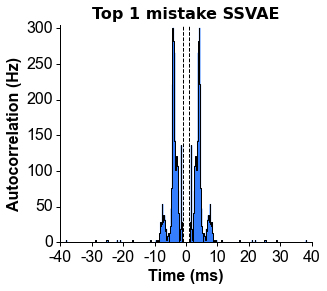


 ----- 

Cell: PkC_ss mistaken 8 times. 

Most common mislabelling: GoC 



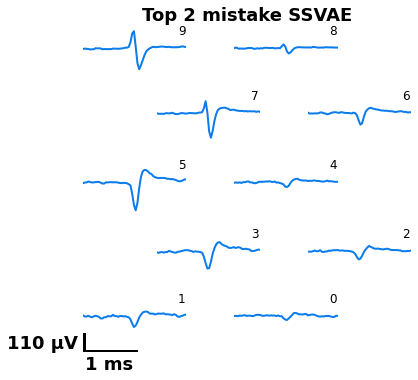

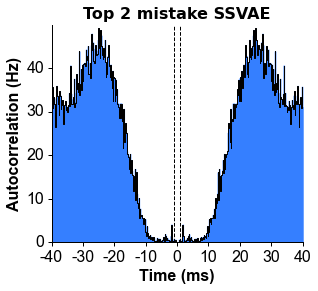


 ----- 

Cell: GoC mistaken 7 times. 

Most common mislabelling: GrC 



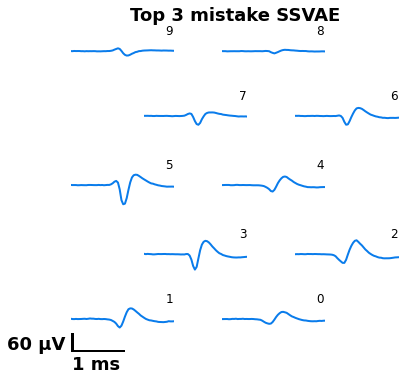

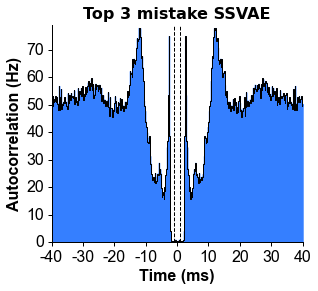


 ----- 

Cell: MFB mistaken 7 times. 

Most common mislabelling: GoC 



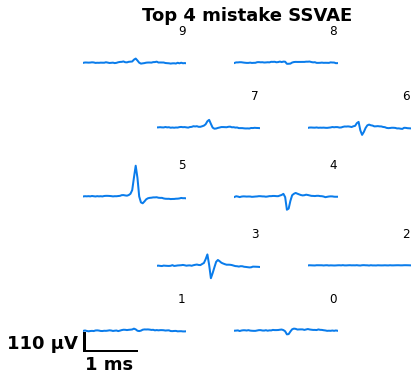

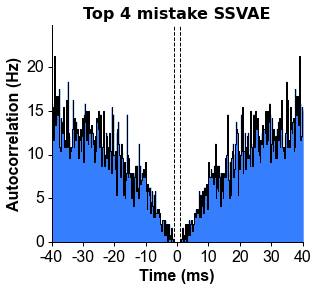


 ----- 



In [10]:
for i, mistake_idx in enumerate(top5_mistakes_idx):
    print(
        f"Cell: {CORRESPONDENCE[DATASET.targets[mistake_idx]]} mistaken {mistakes[mistake_idx]} times. \n"
    )
    print(
        f"Most common mislabelling: {CORRESPONDENCE[np.bincount(predictions_array[:,mistake_idx]).argmax()]} \n"
    )
    npyx.plt_wvf(
        DATASET.wf[mistake_idx].reshape(N_CHANNELS, CENTRAL_RANGE).T,
        title=f"Top {i} mistake SSVAE",
        saveFig=False,
        figw_inch=6,
        figh_inch=6,
    )
    npyx.plot_acg(
        "hello",
        i + 100,
        0.2,
        80,
        train=DATASET.spikes_list[mistake_idx],
        title=f"Top {i} mistake SSVAE",
        saveFig=False,
    )
    plt.show()
    print("\n ----- \n")


# FixMatch Statistics

In [11]:
f1_list = h5.load("models/FixMatch saves/fixmatch_f1.pkl")
accuracy_list = h5.load("models/FixMatch saves/fixmatch_accuracies.pkl")
confusion_list = []
for x in range(2**16):
    if os.path.exists(f"models/FixMatch saves/fixm_outputs_{x}.pkl"):
        preds = h5.load(f"models/FixMatch saves/fixm_outputs_{x}.pkl")
        true = h5.load(f"models/FixMatch saves/fixm_targets_{x}.pkl")
        confusion = confusion_matrix(true, preds, labels = np.arange(0,6))
        confusion_list.append(confusion)
    else:
        continue
f1s = np.array(f1_list)
accuracies = np.array(accuracy_list)

In [12]:
print(f"Mean F1 score: {f1s.mean() * 100}, std F1 score: {f1s.std() * 100}")
print(f"Mean accuracy: {accuracies.mean()}, std accuracy: {accuracies.std()}")

Mean F1 score: 36.83578615059623, std F1 score: 7.732290589557744
Mean accuracy: 48.53610920083934, std accuracy: 9.334499135285286


Text(69.0, 0.5, 'Predicted label')

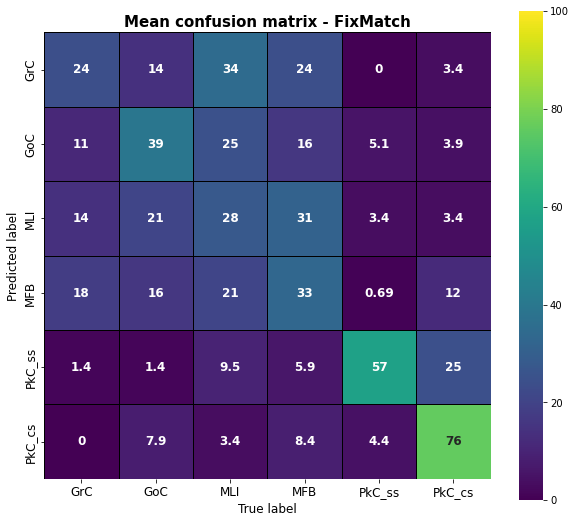

In [13]:
confusion = np.stack(confusion_list, axis=2).mean(
    axis=2
)
mean_confusion = (
    confusion / (np.sum(confusion, axis=1)[:, np.newaxis]) * 100
) 
mask = ~(np.eye(mean_confusion.shape[0]).astype(bool))

fig, ax = plt.subplots(figsize=(10, 9))
ax = sns.heatmap(
    mean_confusion,
    annot=mean_confusion,
    cmap="viridis",
    cbar=True,
    linewidths=1,
    linecolor="black",
    square=True,
    vmin=0,
    vmax=100,
    annot_kws={"fontsize": 12, "fontweight": "bold"},
)

x_labels = [int(ax.get_xticklabels()[i].get_text()) for i in range(6)]
y_labels = [int(ax.get_yticklabels()[i].get_text()) for i in range(6)]

ax.set_xticklabels(
    pd.Series(x_labels).replace(to_replace=CORRESPONDENCE).to_numpy(),
    fontsize=12,
)
ax.set_yticklabels(
    pd.Series(y_labels).replace(to_replace=CORRESPONDENCE).to_numpy(),
    fontsize=12,
)
ax.set_title("Mean confusion matrix - FixMatch", fontsize=15, fontweight="bold")
ax.set_xlabel("True label", fontsize=12)
ax.set_ylabel("Predicted label", fontsize=12)
